In [17]:
!pip uninstall tensorflow
!pip install tensorflow==2.1.0
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available() == True)

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 421.8MB 28kB/s 
     |████████████████████████████████| 450kB 42.4MB/s 
     |████████████████████████████████| 3.9MB 30.3MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Succes

1.15.0
True


In [2]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import plot_model
import pandas as pd
from scipy.stats import norm
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
# run params
SECTION = 'gan'
RUN_ID = '0003'
DATA_NAME = 'celeb'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [0]:
os.environ['KAGGLE_USERNAME'] = 'kimhaggie' # 독자의 캐글 ID
os.environ['KAGGLE_KEY'] = 'bf6a513484128eb597cf644e867f53d7' # 독자의 캐글 API Token

In [8]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:41<00:00, 58.1MB/s]
100% 1.33G/1.33G [00:41<00:00, 34.6MB/s]


In [9]:
!unzip celeba-dataset.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/197620.jpg  
  in

In [0]:
BATCH_SIZE = 64
IMAGE_SIZE = 64

In [0]:
def load_celeb(data_name, image_size, batch_size):
    data_folder = data_name

    data_gen = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)

    x_train = data_gen.flow_from_directory(data_folder
                                            , target_size = (image_size,image_size)
                                            , batch_size = batch_size
                                            , shuffle = True
                                            , class_mode = 'input'
                                            , subset = "training"
                                                )

    return x_train

In [8]:
x_train = load_celeb('img_align_celeba',IMAGE_SIZE,BATCH_SIZE)

Found 202599 images belonging to 1 classes.


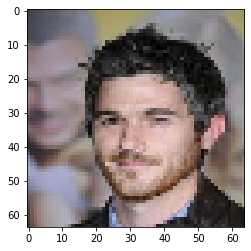

In [9]:
plt.imshow((x_train[0][0][0]+1)/2)

In [0]:
from functools import partial
tf.compat.v1.disable_eager_execution()

class RandomWeightedAverage(tf.keras.layers.Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = tf.keras.backend.random_uniform((self.batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self
        , input_dim
        , critic_conv_filters
        , critic_conv_kernel_size
        , critic_conv_strides
        , critic_batch_norm_momentum
        , critic_activation
        , critic_dropout_rate
        , critic_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , grad_weight
        , z_dim
        , batch_size
        ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_size = critic_conv_kernel_size
        self.critic_conv_strides = critic_conv_strides
        self.critic_batch_norm_momentum = critic_batch_norm_momentum
        self.critic_activation = critic_activation
        self.critic_dropout_rate = critic_dropout_rate
        self.critic_learning_rate = critic_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser

        self.z_dim = z_dim

        self.n_layers_critic = len(critic_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02) # 'he_normal' #RandomNormal(mean=0., stddev=0.02)
        self.grad_weight = grad_weight
        self.batch_size = batch_size


        self.d_losses = []
        self.g_losses = []
        self.epoch = 0

        self._build_critic()
        self._build_generator()

        self._build_adversarial()


    #@tf.function()
    def gradient_penalty_loss(self, y_true, y_pred, interpolated_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        #print(y_pred)
        gradients = tf.keras.backend.gradients(y_pred, interpolated_samples)[0]
        print(gradients)
        # compute the euclidean norm by squaring ...
        gradients_sqr = tf.keras.backend.square(gradients)
        #print("1",gradients_sqr.shape)
        #   ... summing over the rows ...
        gradients_sqr_sum = tf.keras.backend.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #print("2",gradients_sqr_sum.shape)
        #   ... and sqrt
        gradient_l2_norm = tf.keras.backend.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = tf.keras.backend.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return tf.keras.backend.mean(gradient_penalty)

    def wasserstein(self, y_true, y_pred):
        return -tf.keras.backend.mean(y_true * y_pred)

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = tf.keras.layers.LeakyReLU(alpha = 0.2)
        else:
            layer = tf.keras.layers.Activation(activation)
        return layer

    def _build_critic(self):

        ### THE critic
        critic_input = tf.keras.layers.Input(shape=self.input_dim, name='critic_input')

        x = critic_input

        for i in range(self.n_layers_critic):

            x = tf.keras.layers.Conv2D(
                filters = self.critic_conv_filters[i]
                , kernel_size = self.critic_conv_kernel_size[i]
                , strides = self.critic_conv_strides[i]
                , padding = 'same'
                , name = 'critic_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.critic_batch_norm_momentum and i > 0:
                x = tf.keras.layers.BatchNormalization(momentum = self.critic_batch_norm_momentum)(x)

            x = self.get_activation(self.critic_activation)(x)

            if self.critic_dropout_rate:
                x = tf.keras.layers.Dropout(rate = self.critic_dropout_rate)(x)

        x = tf.keras.layers.Flatten()(x)

        # x = Dense(512, kernel_initializer = self.weight_init)(x)

        # x = self.get_activation(self.critic_activation)(x)
        
        critic_output = tf.keras.layers.Dense(1, activation=None
        , kernel_initializer = self.weight_init
        )(x)

        self.critic = tf.keras.Model(critic_input, critic_output)

    def _build_generator(self):

        ### THE generator

        generator_input = tf.keras.layers.Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = tf.keras.layers.Dense(np.prod(self.generator_initial_dense_layer_size), kernel_initializer = self.weight_init)(x)
        if self.generator_batch_norm_momentum:
            x = tf.keras.layers.BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)
        
        x = self.get_activation(self.generator_activation)(x)

        x = tf.keras.layers.Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = tf.keras.layers.Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = tf.keras.layers.UpSampling2D()(x)
                x = tf.keras.layers.Conv2D(
                filters = self.generator_conv_filters[i]
                , kernel_size = self.generator_conv_kernel_size[i]
                , padding = 'same'
                , name = 'generator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)
            else:

                x = tf.keras.layers.Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = tf.keras.layers.BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
                
            else:
                x = tf.keras.layers.Activation('tanh')(x)

        generator_output = x
        self.generator = tf.keras.Model(generator_input, generator_output)




    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = tf.keras.optimizers.Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = tf.keras.optimizers.RMSprop(lr=lr)
        else:
            opti = tf.keras.optimizers.Adam(lr=lr)

        return opti


    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val

    def _build_adversarial(self):
                
        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.set_trainable(self.generator, False)

        # Image input (real sample)
        real_img = tf.keras.layers.Input(shape=self.input_dim)

        # Fake image
        z_disc = tf.keras.layers.Input(shape=(self.z_dim,))
        fake_img = self.generator(z_disc)

        # critic determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage(self.batch_size)([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'interpolated_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          interpolated_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = tf.keras.Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])

        self.critic_model.compile(
            loss=[self.wasserstein,self.wasserstein, partial_gp_loss]
            ,optimizer=self.get_opti(self.critic_learning_rate)
            ,loss_weights=[1, 1, self.grad_weight]
            )
        
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.set_trainable(self.critic, False)
        self.set_trainable(self.generator, True)

        # Sampled noise for input to generator
        model_input = tf.keras.layers.Input(shape=(self.z_dim,))
        # Generate images based of noise
        img = self.generator(model_input)
        # Discriminator determines validity
        model_output = self.critic(img)
        # Defines generator model
        self.model = tf.keras.Model(model_input, model_output)

        self.model.compile(optimizer=self.get_opti(self.generator_learning_rate)
        , loss=self.wasserstein
        )

        self.set_trainable(self.critic, True)

    def train_critic(self, x_train, batch_size, using_generator):

        valid = np.ones((batch_size,1), dtype=np.float32)
        fake = -np.ones((batch_size,1), dtype=np.float32)
        dummy = np.zeros((batch_size, 1), dtype=np.float32) # Dummy gt for gradient penalty

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
    
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))

        d_loss = self.critic_model.train_on_batch([true_imgs, noise], [valid, fake, dummy])
        return d_loss

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1), dtype=np.float32)
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)


    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 10
    , n_critic = 5
    , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            if epoch % 100 == 0:
                critic_loops = 5
            else:
                critic_loops = n_critic

            for _ in range(critic_loops):
                d_loss = self.train_critic(x_train, batch_size, using_generator)

            g_loss = self.train_generator(batch_size)

            
            print ("%d (%d, %d) [D loss: (%.1f)(R %.1f, F %.1f, G %.1f)] [G loss: %.1f]" % (epoch, critic_loops, 1, d_loss[0], d_loss[1],d_loss[2],d_loss[3],g_loss))
            


            self.d_losses.append(d_loss)
            self.g_losses.append(g_loss)

            # If at save interval => save generated image samples
            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)
                

            self.epoch+=1


    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        #Rescale images 0 - 1

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()




    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.critic, to_file=os.path.join(run_folder ,'viz/critic.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



            
    def save(self, folder):

            with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
                pickle.dump([
                    self.input_dim
                    , self.critic_conv_filters
                    , self.critic_conv_kernel_size
                    , self.critic_conv_strides
                    , self.critic_batch_norm_momentum
                    , self.critic_activation
                    , self.critic_dropout_rate
                    , self.critic_learning_rate
                    , self.generator_initial_dense_layer_size
                    , self.generator_upsample
                    , self.generator_conv_filters
                    , self.generator_conv_kernel_size
                    , self.generator_conv_strides
                    , self.generator_batch_norm_momentum
                    , self.generator_activation
                    , self.generator_dropout_rate
                    , self.generator_learning_rate
                    , self.optimiser
                    , self.grad_weight
                    , self.z_dim
                    , self.batch_size
                    ], f)

            self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.critic.save(os.path.join(run_folder, 'critic.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))
        #pickle.dump(self, open( os.path.join(run_folder, "obj.pkl"), "wb" ))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

In [76]:
gan = WGANGP(input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
        , critic_conv_filters = [64,128,256,512]
        , critic_conv_kernel_size = [5,5,5,5]
        , critic_conv_strides = [2,2,2,2]
        , critic_batch_norm_momentum = None
        , critic_activation = 'leaky_relu'
        , critic_dropout_rate = None
        , critic_learning_rate = 0.0002
        , generator_initial_dense_layer_size = (4, 4, 512)
        , generator_upsample = [1,1,1,1]
        , generator_conv_filters = [256,128,64,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2,2,2,2]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0002
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 100
        , batch_size = BATCH_SIZE
        )

if mode == 'build':
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

Tensor("loss_6/model_73_2_loss/gradients/model_73_2/critic_conv_0/Conv2D_grad/Conv2DBackpropInput:0", shape=(None, 64, 64, 3), dtype=float32)


In [69]:
gan.critic.summary()

Model: "model_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 64, 64, 3)]       0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_144 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_145 (LeakyReLU)  (None, 16, 16, 128)       0         
_________________________________________________________________
critic_conv_2 (Conv2D)       (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_146 (LeakyReLU)  (None, 8, 8, 256)         0  

In [70]:
gan.generator.summary()

Model: "model_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_37 (Dense)             (None, 8192)              827392    
_________________________________________________________________
batch_normalization_72 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_148 (LeakyReLU)  (None, 8192)              0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 4, 4, 512)         0         
_________________________________________________________________
generator_conv_0 (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_73 (Batc (None, 8, 8, 256)         102

In [71]:
gan.critic_model.summary()

Model: "model_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model_70 (Model)                (None, 64, 64, 3)    5168003     input_8[0][0]                    
__________________________________________________________________________________________________
random_weighted_average_18 (Ran [(None, 64, 64, 3),  0           input_7[0][0]                    
                                                                 model_70[1][0]            

In [0]:
EPOCHS = 3000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5
BATCH_SIZE = 64

In [77]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , using_generator = True
)

0 (5, 1) [D loss: (-3.3)(R -8.5, F 0.1, G 0.5)] [G loss: -3.8]
1 (5, 1) [D loss: (-104.2)(R -173.4, F 2.0, G 6.7)] [G loss: -48.8]
2 (5, 1) [D loss: (-130.0)(R -204.6, F 2.8, G 7.2)] [G loss: -63.6]
3 (5, 1) [D loss: (-137.4)(R -218.9, F 3.7, G 7.8)] [G loss: -69.9]
4 (5, 1) [D loss: (-140.2)(R -224.1, F 4.4, G 7.9)] [G loss: -69.1]
5 (5, 1) [D loss: (-138.2)(R -230.2, F 4.8, G 8.7)] [G loss: -51.4]
6 (5, 1) [D loss: (-155.9)(R -224.8, F 1.7, G 6.7)] [G loss: -63.4]
7 (5, 1) [D loss: (-146.3)(R -222.7, F -2.7, G 7.9)] [G loss: -16.6]
8 (5, 1) [D loss: (-155.5)(R -222.3, F -10.7, G 7.7)] [G loss: -30.9]
9 (5, 1) [D loss: (-142.2)(R -192.2, F -10.4, G 6.0)] [G loss: 14.1]


KeyboardInterrupt: ignored

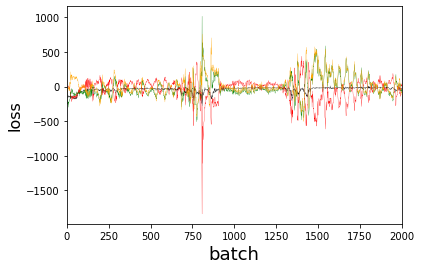

In [74]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()